<a href="https://colab.research.google.com/github/16A0/til/blob/master/geodesic_znah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Geodesic distance transform

This notebook shows how Geodesic Discance Transform (GDT) using Fast Sweeping Method (FSM) can be implemented using Python. GDT can be thought of as a computation of shortest pathes on an image plane with a given cost function. It can be used as a part of more complex image processing tasks such as segmentation or coloring [[1]](http://research.microsoft.com/apps/pubs/default.aspx?id=81528).

The description of different GDT construction methods can be found in [[2]](http://www.eng.biu.ac.il/~weberof/Publications/PMM/Parallel_Algorithms_for_Approximation_of_Distance_Maps_on_Parametric_Surfaces.pdf).

In [ ]:
!pip install -q numba
!pip install -q moviepy

source 
https://github.com/znah/notebooks/blob/master/geodesic.ipynb

In [ ]:
# some preparations first
import numpy as np
import scipy.ndimage as nd
import PIL.Image
import itertools as it
import matplotlib.pylab as pl
import moviepy.editor as mvp
from IPython.display import Image, display
from google.colab import files
import numba

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3727360/45929032 bytes (8.1%)7323648/45929032 bytes (15.9%)11141120/45929032 bytes (24.3%)15310848/45929032 bytes (33.3%)19136512/45929032 bytes (41.7%)23240704/45929032 bytes (50.6%)27017216/45929032 bytes (58.8%)30769152/45929032 bytes (67.0%)34619392/45929032 bytes (75.4%)38608896/45929032 bytes (84.1%)42491904/45929032 bytes (92.5%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

We use image gradient magnitude to costruct our cost function.

In [ ]:
!wget -q https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/515px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg -O img.jpg

In [ ]:
!wget -q https://upload.wikimedia.org/wikipedia/commons/thumb/9/94/Van_Gogh_-_Bildnis_Patience_Escalier1.jpeg/800px-Van_Gogh_-_Bildnis_Patience_Escalier1.jpeg -O img.jpg


In [ ]:
img = PIL.Image.open('img.jpg').convert('L')
w = img.size[0]
img = img.crop([0, 0, w, w])
img = np.float32(img)/255.0

`sweep` function is the core of the algorithm. It propogates shortest path wavefront in right-down direction. We use Numba to accelerate pixel iteration.

In [ ]:
@numba.jit
def sweep(A, Cost):
    max_diff = 0.0
    for i in range(1, A.shape[0]):
        for j in range(1, A.shape[1]):
            t1, t2 = A[i, j-1], A[i-1, j]
            C = Cost[i, j]
            if abs(t1-t2) > C:
                t0 = min(t1, t2) + C  # handle degenerate case
            else:    
                t0 = 0.5*(t1 + t2 + np.sqrt(2*C*C - (t1-t2)**2))
            max_diff = max(max_diff, A[i, j] - t0)
            A[i, j] = min(A[i, j], t0)
    return max_diff


`GDT` function uses NumPy array slicing to sweep the wavefront in four possible directions.

In [ ]:
def GDT(A, C, max_iter_n=80, max_diff=0.1):
    A = A.copy()
    sweeps = [A, A[:,::-1], A[::-1], A[::-1,::-1]]
    costs = [C, C[:,::-1], C[::-1], C[::-1,::-1]]
    for i, (a, c) in enumerate(it.cycle(zip(sweeps, costs))):
        r = sweep(a, c)
        print(i, r)
        if r < max_diff or i >= max_iter_n:
            break
    return A

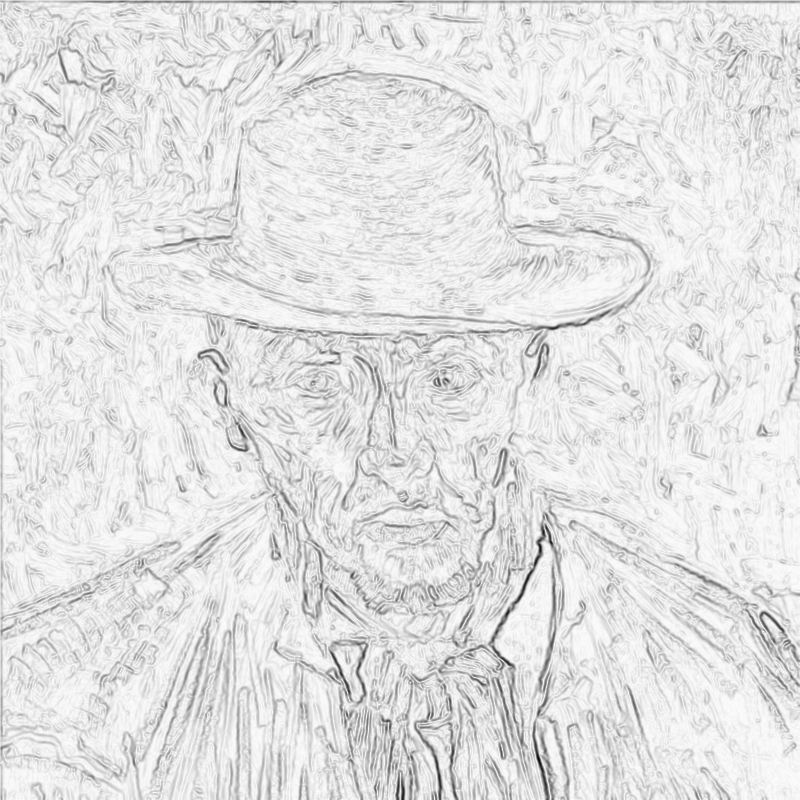

In [ ]:
img1 = (img-img.min()) / img.ptp()
G = nd.gaussian_gradient_magnitude(img1, 1.5)
Cost = 1.0+G*200
vis = np.uint8(1.0-Cost/Cost.max()*255.0)
PIL.Image.fromarray(vis)

In [ ]:
%%time
A = np.zeros_like(Cost) # create distance accumulation array
A[:] = 1e6           # fill it with large values to mark
                     # cells with unknown distance
A[190, 235] = 0      # set the source

A = GDT(A, Cost)

0 999994.9297537804
1 999982.8623962402
2 999986.8161296844
3 999303.4931944212
4 499.38807614151915
5 270.989013671875
6 141.6741293964226
7 55.53250774425328
8 74.06785542492162
9 68.33257000391859
10 39.010712533977994
11 13.535949071934965
12 23.143518439458603
13 16.90289532139832
14 16.407855664339422
15 9.115500983655465
16 13.112156902049264
17 10.404456833594395
18 9.37646484375
19 6.718139013684549
20 10.30656551418133
21 6.5003023559399935
22 6.555475869472502
23 4.689165346185746
24 6.500793045006276
25 3.027377538384826
26 6.004923722723106
27 3.779235511530487
28 4.3680419921875
29 3.2561983968823824
30 4.345430125925304
31 3.0087379446099476
32 2.8082780846684727
33 1.5645568780323629
34 2.1811087419598607
35 1.4939996325917946
36 2.125623923278681
37 1.2941243038080756
38 1.0167722330065772
39 0.9179251142711564
40 0.9773572510298436
41 0.9089267559700147
42 0.7708024089181436
43 0.6076145344154611
44 0.7261384620305762
45 0.6926181622200147
46 0.5898854019028477
47 0.5

Here is the contour plot of the GDT with the given cost function. Note, how isolines tend to follow image edges.

In [ ]:
duration = 0.5

def frame(t):
  fig = pl.figure(figsize=(8, 8))
  hi = A.max()
  n = 40
  trs = np.linspace(0, hi, n+1)
  t /= duration
  pl.contour(A, trs+t*hi/n, origin='image', colors='black')
  ax = pl.gca()
  ax.set_facecolor('white')
  ax.xaxis.set_ticklabels([])
  ax.yaxis.set_ticklabels([])
  pl.tight_layout()
  pl.grid()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)[..., :3]
  pl.close()
  return img

#PIL.Image.fromarray(frame(0))
clip = mvp.VideoClip(frame, duration=duration)
clip.write_videofile('out.mp4', fps=30.0)

[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


 94%|█████████▍| 15/16 [00:07<00:00,  1.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 



In [ ]:
clip.write_gif('out.gif', fps=30, opt='wu')


[MoviePy] Building file out.gif with imageio


 94%|█████████▍| 15/16 [00:07<00:00,  1.88it/s]


In [ ]:
mvp.ipython_display('out.mp4', loop=True)

In [ ]:
files.download('out.gif')